In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import cv2
import mediapipe as mp
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
data_raw = pd.read_csv('ASLImages/sign_mnist_train.csv', sep=",")
test_data_raw = pd.read_csv('ASLImages/sign_mnist_test.csv', sep=",")

labels = data_raw['label']
data_raw.drop('label', axis=1, inplace=True)
labels_test = test_data_raw['label']
test_data_raw.drop('label', axis=1, inplace=True)

data = data_raw.values
labels = labels.values
test_data = test_data_raw.values
labels_test = labels_test.values

In [4]:
import string

alph = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:"f", 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l', 12:'m', 13:'n',
        14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x', 24:'y', 25:'z'}


In [5]:
def reshape_to_2d(data, dim):
    reshaped = []
    for i in data:
        reshaped.append(i.reshape(1, dim, dim))

    return np.array(reshaped)

In [6]:
data = reshape_to_2d(data, 28)

x = torch.FloatTensor(data)
y = torch.LongTensor(labels.tolist())

test_labels = torch.LongTensor(labels_test.tolist())

test_data_formated = reshape_to_2d(test_data, 28)
test_data_formated = torch.FloatTensor(test_data_formated)

In [7]:
epochs = 50
batch_size = 100
learning_rate = 0.001

In [8]:
class Network(nn.Module): 
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(20, 30, 3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3 = nn.Linear(30 * 3 * 3, 270) 
        self.fc4 = nn.Linear(270, 26) 
        
        self.softmax = nn.LogSoftmax(dim=1)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = x.view(-1, 30 * 3 * 3) 
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    
    
    def test(self, predictions, labels):
        
        self.eval()
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        print("Correct predictions: %5d / %5d (%5f)" % (correct, len(predictions), acc))
        
    
    def evaluate(self, predictions, labels):
                
        correct = 0
        for p, l in zip(predictions, labels):
            if p == l:
                correct += 1
        
        acc = correct / len(predictions)
        return(acc)
        

In [9]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=270, bias=True)
  (fc4): Linear(in_features=270, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [10]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_func = nn.CrossEntropyLoss()

In [11]:
loss_log = []
acc_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size] 
        
        optimizer.zero_grad()
        net_out = net(Variable(x_mini))
        
        loss = loss_func(net_out, Variable(y_mini))
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            #pred = net(Variable(test_data_formated))
            loss_log.append(loss.item())
            acc_log.append(net.evaluate(torch.max(net(Variable(test_data_formated[:500])).data, 1)[1], 
                                        test_labels[:500]))
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 2.738284
Epoch: 2 - Loss: 1.655190
Epoch: 3 - Loss: 1.130758
Epoch: 4 - Loss: 0.876738
Epoch: 5 - Loss: 0.999581
Epoch: 6 - Loss: 0.866131
Epoch: 7 - Loss: 0.451756
Epoch: 8 - Loss: 0.659407
Epoch: 9 - Loss: 0.240886
Epoch: 10 - Loss: 0.223151
Epoch: 11 - Loss: 0.550190
Epoch: 12 - Loss: 0.167997
Epoch: 13 - Loss: 0.165540
Epoch: 14 - Loss: 0.188893
Epoch: 15 - Loss: 0.146525
Epoch: 16 - Loss: 0.151788
Epoch: 17 - Loss: 0.162112
Epoch: 18 - Loss: 0.078624
Epoch: 19 - Loss: 0.083588
Epoch: 20 - Loss: 0.075697
Epoch: 21 - Loss: 0.060434
Epoch: 22 - Loss: 0.206044
Epoch: 23 - Loss: 0.236558
Epoch: 24 - Loss: 0.088622
Epoch: 25 - Loss: 0.205568
Epoch: 26 - Loss: 0.044918
Epoch: 27 - Loss: 0.074236
Epoch: 28 - Loss: 0.054949
Epoch: 29 - Loss: 0.011111
Epoch: 30 - Loss: 0.012222
Epoch: 31 - Loss: 0.082378
Epoch: 32 - Loss: 0.073913
Epoch: 33 - Loss: 0.036373
Epoch: 34 - Loss: 0.021141
Epoch: 35 - Loss: 0.044973
Epoch: 36 - Loss: 0.183892
Epoch: 37 - Loss: 0.108285
Epoch: 38 

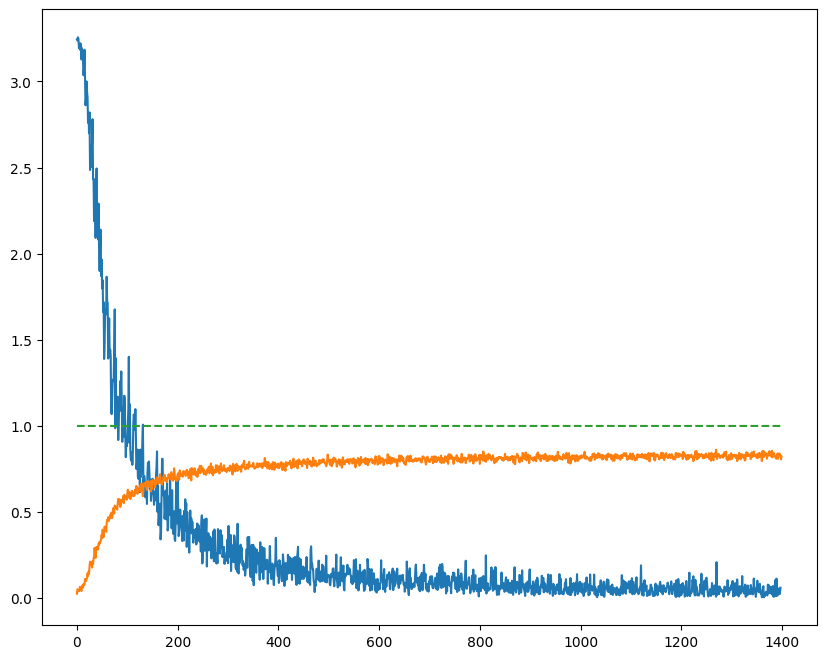

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log[2:])
plt.plot(acc_log)
plt.plot(np.ones(len(acc_log)), linestyle='dashed')

Prediction: h
Actual Label: h
Prediction: i
Actual Label: i
Prediction: i
Actual Label: i
Prediction: r
Actual Label: v


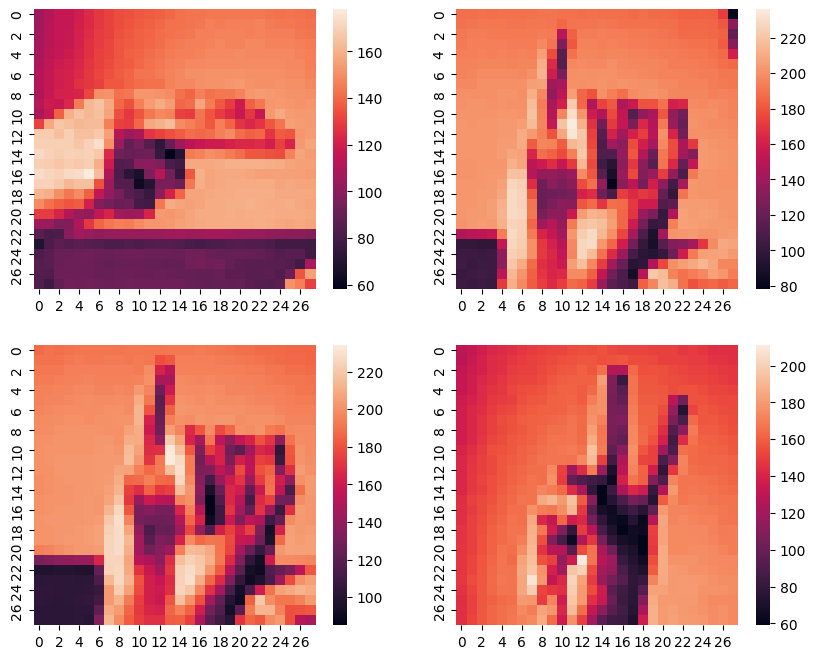

In [13]:
plt.figure(figsize=(10, 8))

sample = 30
pixels = test_data[sample].reshape(28, 28)
plt.subplot(221)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 42
pixels = test_data[sample].reshape(28, 28)
plt.subplot(222)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 100
pixels = test_data[sample].reshape(28, 28)
plt.subplot(223)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

sample = 22
pixels = test_data[sample].reshape(28, 28)
plt.subplot(224)
sns.heatmap(data=pixels)
lab = labels_test[sample]
test_sample = torch.FloatTensor([test_data[sample].reshape(1, 28, 28).tolist()])
test_var_sample = Variable(test_sample)
net_out_sample = net(test_var_sample)

print("Prediction: {}".format(alph[torch.max(net_out_sample.data, 1)[1].numpy()[0]]))
print("Actual Label: {}".format(alph[lab]))

In [14]:
predictions = net(Variable(test_data_formated))
net.test(torch.max(predictions.data, 1)[1], test_labels)

Correct predictions:  5925 /  7172 (0.826129)


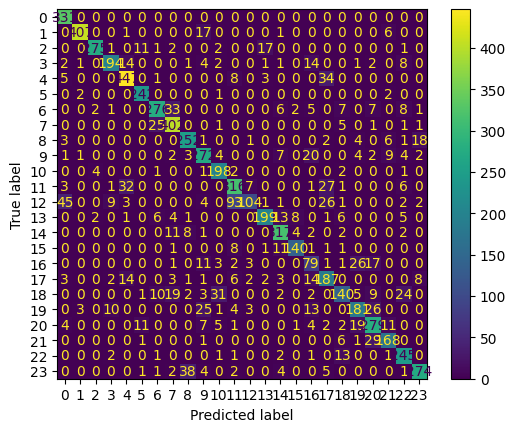

In [16]:
y_true = test_labels
y_pred = torch.max(predictions.data, 1)[1]
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [70]:
model = Network()
model.eval()

mphands = mp.solutions.hands
hands = mphands.Hands()
mp_drawing = mp.solutions.drawing_utils

model = Network()
model.eval()

mphands = mp.solutions.hands
hands = mphands.Hands()
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)

# Check if the camera is opened successfully
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Capture a frame
_, frame = cap.read()

# Check if the frame is valid
if frame is None:
    print("Error: Could not read a frame from the webcam.")
    exit()

# Print frame information
print(frame.shape)  # This should print the shape of the frame (height, width, channels)

cap = cv2.VideoCapture(0)
_, frame = cap.read()
print(frame)
h, w, c = frame.shape

letterpred = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

while True:
    _, frame = cap.read()

    k = cv2.waitKey(1)
    if k % 256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k % 256 == 32:
        # SPACE pressed
        framergbanalysis = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultanalysis = hands.process(framergbanalysis)
        hand_landmarksanalysis = resultanalysis.multi_hand_landmarks
        if hand_landmarksanalysis:
            for handLMsanalysis in hand_landmarksanalysis:
                x_max, y_max, x_min, y_min = w, 0, h, 0
                for lmanalysis in handLMsanalysis.landmark:
                    x, y = int(lmanalysis.x * w), int(lmanalysis.y * h)
                    if x > x_max:
                        x_max = x
                    if x < x_min:
                        x_min = x
                    if y > y_max:
                        y_max = y
                    if y < y_min:
                        y_min = y
                y_min -= 20
                y_max += 20
                x_min -= 20
                x_max += 20

                # Extract the region of interest (ROI) from the frame
                roi = framergbanalysis[y_min:y_max, x_min:x_max]

                # Preprocess the ROI before feeding it into the PyTorch model
                input_tensor = transform(roi)
                input_batch = input_tensor.unsqueeze(0)

                # Make a prediction using the PyTorch model
                with torch.no_grad():
                    output = model(input_batch)

                # Perform post-processing on the output to get the predicted class
                predicted_class = torch.argmax(output).item()
                predicted_letter = letterpred[predicted_class]

                # Display the predicted letter on the frame
                cv2.putText(frame, predicted_letter, (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Hand Sign Detection", frame)

cap.release()
cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Error: Could not read a frame from the webcam.


AttributeError: 'NoneType' object has no attribute 'shape'